 
# Creating a GANTT chart from a CSV file

An example input file `tasks.csv` is provided but its dates should be modified if we expect to generate any gantt chart, 
as the gantt starts in current date.

TODO:
* add connections between the different bars

 
First, we define a function that helps me running this code in jupyter notebook as well as python. 

(Taken from https://stackoverflow.com/questions/15411967/how-can-i-check-if-code-is-executed-in-the-ipython-notebook)

In [1]:

def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter


In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from dateutil.relativedelta import relativedelta
import argparse
import pandas as pd
from pathlib import Path

homedir=str(Path.home())

In [3]:
def read_tasks_from_csv(file_path):
    """     
    function that parses the CSV file containing the info. An example of a file can be found
    in the same folder: tasks.csv
    """
    df = pd.read_csv(file_path)
    df['start'] = pd.to_datetime(df['start'],format='%Y-%m-%d')
    df['end'] = pd.to_datetime(df['end'],format='%Y-%m-%d')
    df.drop(df[df['delete'] == '#'].index, inplace=True)            # remove rows that have been explicitly deleted with
                                                                    # the sign # in the CSV
    for i, row in df.iterrows():
        #df.at[i,'start'] = datetime.strptime(row['start'], '%Y-%m-%d')
        #df.at[i,'end'] = datetime.strptime(row['end'], '%Y-%m-%d')
        df.at[i,'people_responsible'] = row['people_responsible'].split(',')
        df.at[i,'is_milestone'] = bool(int(row['is_milestone']))
    return df

def create_gantt_chart(tasks,months):
    """
    function that makes use of horizontal bar charts from matplotlib to build the GANTT
    The result can be exported as a pop up plot or saved as a figure.
    In this example, the figure is saved in PNG format in the wallpapers folder in Pictures, in order 
    to be used as background in your computer
    """
    # general setup for the plot
    plt.rcParams['figure.constrained_layout.use'] = True
    plt.rcParams['figure.figsize'] = 16, 9
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1
    #plt.rcParams["figure.facecolor"] = "yellow"
    #plt.rcParams["axes.facecolor"] = "blue"

    fig, ax = plt.subplots() 
    xfmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    ax.yaxis.tick_right()
    ax.set_xticks(tasks['end'])
  
    current_date = datetime.now()
    max_end = current_date.date()+relativedelta(months=months)

    print(max_end)
    print(tasks)

    tasks = tasks[(tasks['start'] < str(max_end)) & (tasks['end'] > str(current_date.date()))]

    print(tasks)

    # Set the labels and ticks for y-axis
    labels = tasks['name']
    ax.set_yticks(range(5, len(labels) * 10 + 5, 10))
    ax.set_yticklabels(labels)
    ax.invert_yaxis()
    ax.set_xlim(current_date, max_end)
    ax.set_xlabel('End date')
    ax.set_title('Projects Schedule')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks(rotation=90)
    ax.grid(True)

    print('number of elements:',len(tasks.index))

    # Plot the bars for each task and milestone
    for i, task in tasks.iterrows():
        print(i,task)
        edgecolor = 'black'
        if task['type'] == 'CALL':
            color = 'red'
        elif task['type'] == 'TEACH':
            color = 'blue'
        elif task['type'] == 'IRIS-CC':
            color = 'brown'
        elif task['type'] == 'RESEARCH':
            color = 'green'
        else:
            color = 'brown'

        start = task['start']
        if task['start'] < current_date and task['end'] > current_date:
            # Tasca ja començada
            start = current_date
        
        # some warnings
        if task['end'] == current_date + relativedelta(days=1):
            print ('WARNING: task ',task,' ends TOMORROW!!')
        elif task['end'] == current_date:
            print ('WARNING: task ',task,' ends TODAY!!')

        duration = task['end'] - start

        # plot each horizontal bar and the label       
        if task['is_milestone'] == True:
            linewidth=3
            length=0.1
            color='black'
        else:
            linewidth=0
            length=duration
        ax.barh(i * 10 + 5, length, left=start, height=8, align='center', linewidth=linewidth, edgecolor=edgecolor, color=color, alpha=0.8)
        people = ', '.join(task['people_responsible'])
        ax.text(start, i * 10 + 5, people, ha='right', va='center')

    fig.savefig(homedir+'/Pictures/Wallpapers/gantt.png') # convenient to have it as wallpaper
    #plt.show()

  parse arguments 

In [4]:
parser = argparse.ArgumentParser(description='Generate Gantt chart from CSV file') # Crear un objecte ArgumentParser
parser.add_argument('-c','--csvfile', type=str, help='Path to the CSV file. Default is tasks.csv',default="tasks.csv") # Afegir l'argument per al camí del fitxer CSV
parser.add_argument('-m','--months', type=int, help='Number of months to visualize',default=2) # Afegir l'argument per al camí del fitxer CSV

if is_notebook():
    args = parser.parse_args(args=[]) 
else:
    args = parser.parse_args() 
csv_file_path = args.csvfile 
months = args.months

 read the file and build the gantt 

  delete            name      type      start        end people_responsible  \
0    NaN             FPI     TEACH 2023-06-01 2023-08-31          [Margall]   
1    NaN  Submission TFM     TEACH 2023-06-01 2023-09-10              [Epi]   
2    NaN      Report PhD     TEACH 2023-11-01 2023-11-09          [Romario]   
3    NaN  Submission TFM  RESEARCH 2023-06-01 2023-09-10             [Marc]   
4    NaN  Submission TFM     TEACH 2023-06-01 2023-09-10            [Jorge]   
5    NaN            MCSA     TEACH 2023-10-01 2023-10-01            [Carla]   
6    NaN        Docentia     TEACH 2023-10-06 2023-10-23           [Montse]   
7    NaN  Submission TFM     TEACH 2023-06-01 2023-09-10             [Rudy]   
8    NaN    Cupons ACCIÓ      CALL 2023-04-16 2023-12-01            [Jordi]   

  is_milestone                    web  
0        False                    NaN  
1        False                    NaN  
2        False                    NaN  
3        False                    NaN  
4        

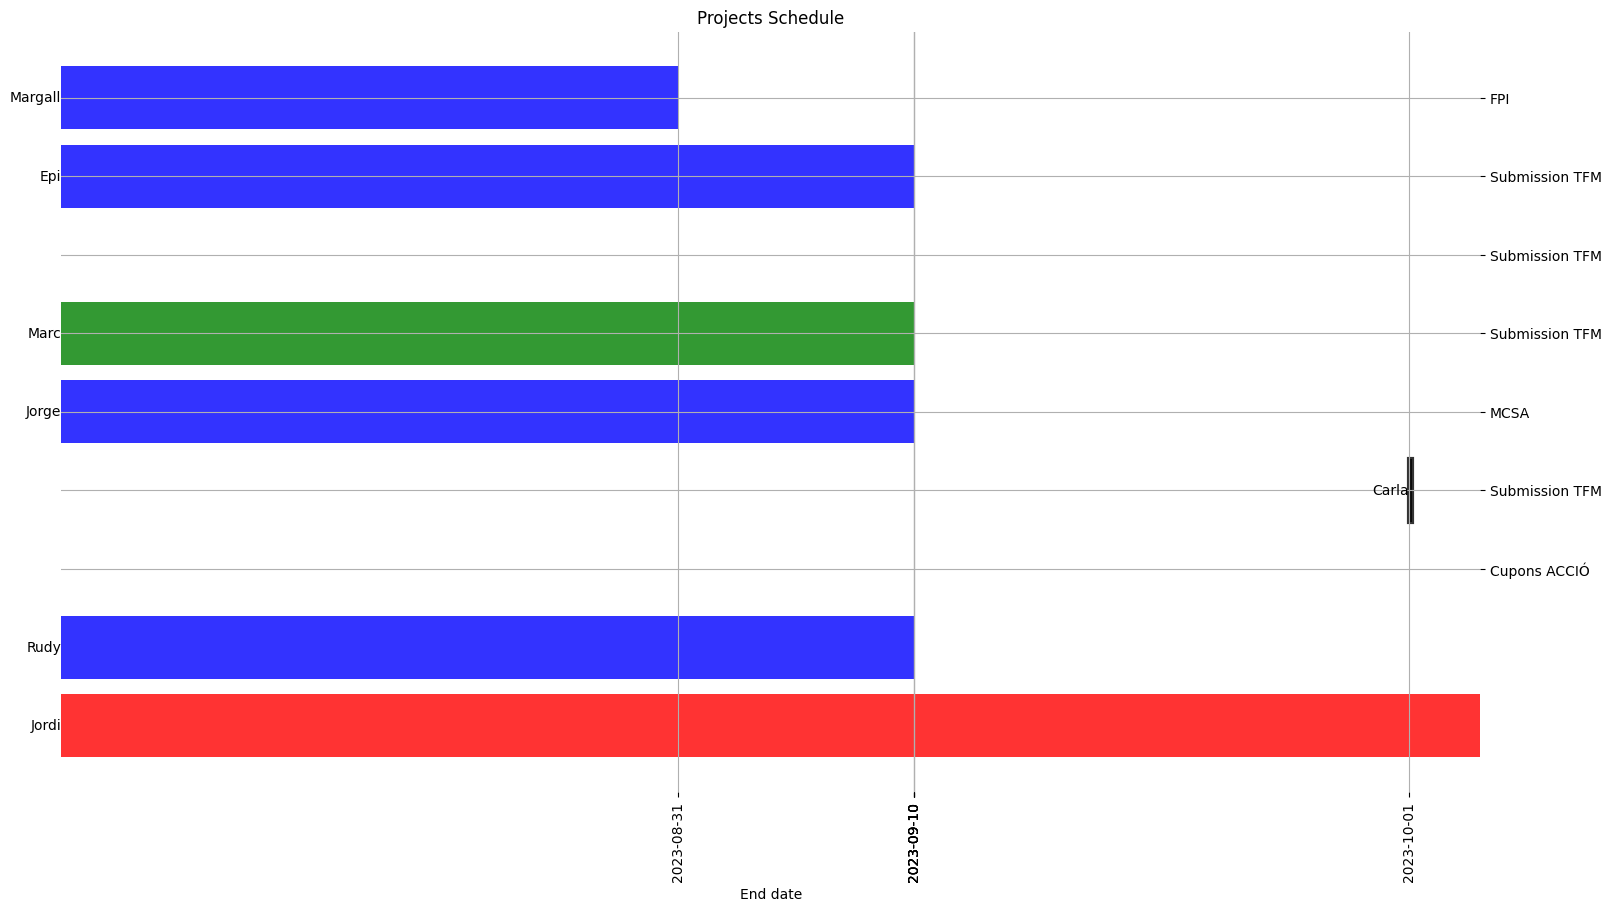

In [5]:
tasks = read_tasks_from_csv(csv_file_path)
if is_notebook():
    print(tasks)
create_gantt_chart(tasks,months)